1A) Well Log Data

    Read the LAS file.
    Plot the Gamma Ray curve vs. Depth.
    Extract the latitude/longitude of this well


In [1]:
import lasio
import matplotlib.pyplot as plt

In [2]:
#read las file
las = lasio.read('C:\\Users\\conte\\OneDrive\\Escritorio\\Subsurface_data_assessment\\subsurface_data_assessment-main\\data\\part1\\42000000_Petro1.las')

In [3]:
#reset MD index
df = las.df().reset_index()

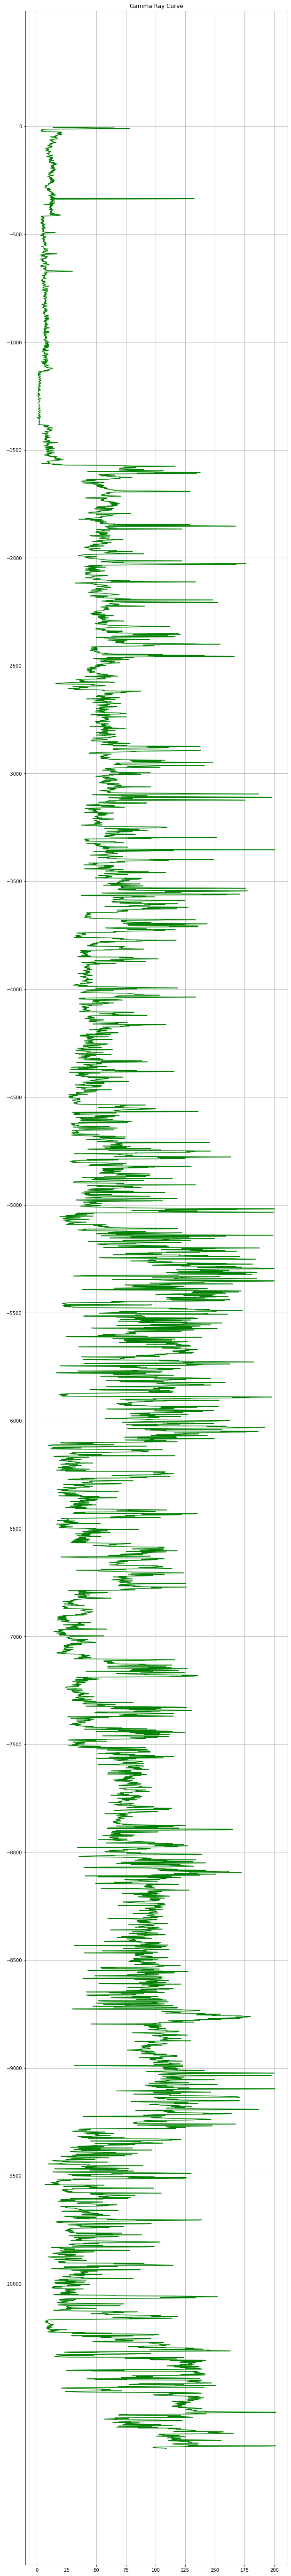

In [4]:
# Plot GR vs MD
plt.figure(figsize=(10,100))
plt.plot(las['GR'], -las['MD'], color='green')
plt.grid(True)
yticks=[0,-500,-1000,-1500,-2000,-2500,-3000,-3500,-4000,-4500,-5000,-5500,-6000,-6500,-7000,-7500,-8000,-8500,-9000,-9500,-10000]
plt.yticks(yticks)
plt.title("Gamma Ray Curve")
plt.show()

In [5]:
# Get Lat and Long from las header
lat, long =las.header['Well'][7].value, las.header['Well'][8].value
print(f"Well Latitude: {lat}, Well Longitude: {long}")

Well Latitude: -103.663049999873, Well Longitude: 31.5180500000053


1B) Attribute Grids

    Read the attribute grid.
    Plot the spatial variation of the ATTR1 property
    Show the location of the well from part A.
    Bonus: what is the value of ATTR1 at the well location from part A?


In [6]:
import pandas as pd

In [7]:
#read csv file with attrs
attr = pd.read_csv('C:\\Users\\conte\\OneDrive\\Escritorio\\Subsurface_data_assessment\\subsurface_data_assessment-main\\data\\part1\\ATTR1_map.csv')

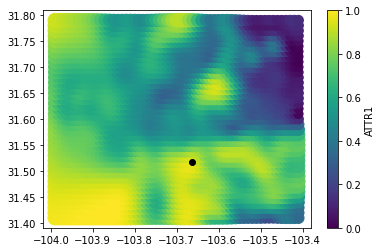

Attribute at latitude: -103.66 and longitude 31.52 is:  Series([], Name: ATTR1, dtype: float64)


In [8]:
x = attr['longitude']
y = attr['latitude']
z = attr['ATTR1']
plt.scatter(x, y, s=200*z, c=z, alpha=1)
plt.scatter(lat, long, color='black')
plt.colorbar(label='ATTR1')
plt.grid(False)
plt.show()

attrfilter=attr.round(2)
filterlat = attrfilter['latitude']==round(lat,2)
filterlong = attrfilter['longitude']==round(long,2)

attr_well = attrfilter[filterlat & filterlong]['ATTR1']


print(f'Attribute at latitude: {round(lat,2)} and longitude {round(long,2)} is: ', attr_well)


1C) Production Data

    Read the production file.
    Plot the monthly production from the well in part A
    Determine the total production (oil, gas, water) for each well.
    Determine the total barrel of oil equivalent (BOE) produced for each well. Use a suitable conversion factor to convert MCF gas to BOE, and assume 1 bbl oil = 1 BOE.
    Save this summary data to a csv file for all wells that produced more than 100,000 BOE. How many wells have BOE > 100,000?
    Determine the well with the highest total BOE.


In [9]:
import seaborn as sns
import matplotlib.ticker as ticker

In [17]:
#read monthly prod csv file
df_monthly = pd.read_csv('C:\\Users\\conte\\OneDrive\\Escritorio\\Subsurface_data_assessment\\subsurface_data_assessment-main\\data\\part1\\MonthlyProduction.csv')
#fill NaN's with 0
df_monthly.fillna(0)
#get wells
wells = df_monthly['API'].unique()

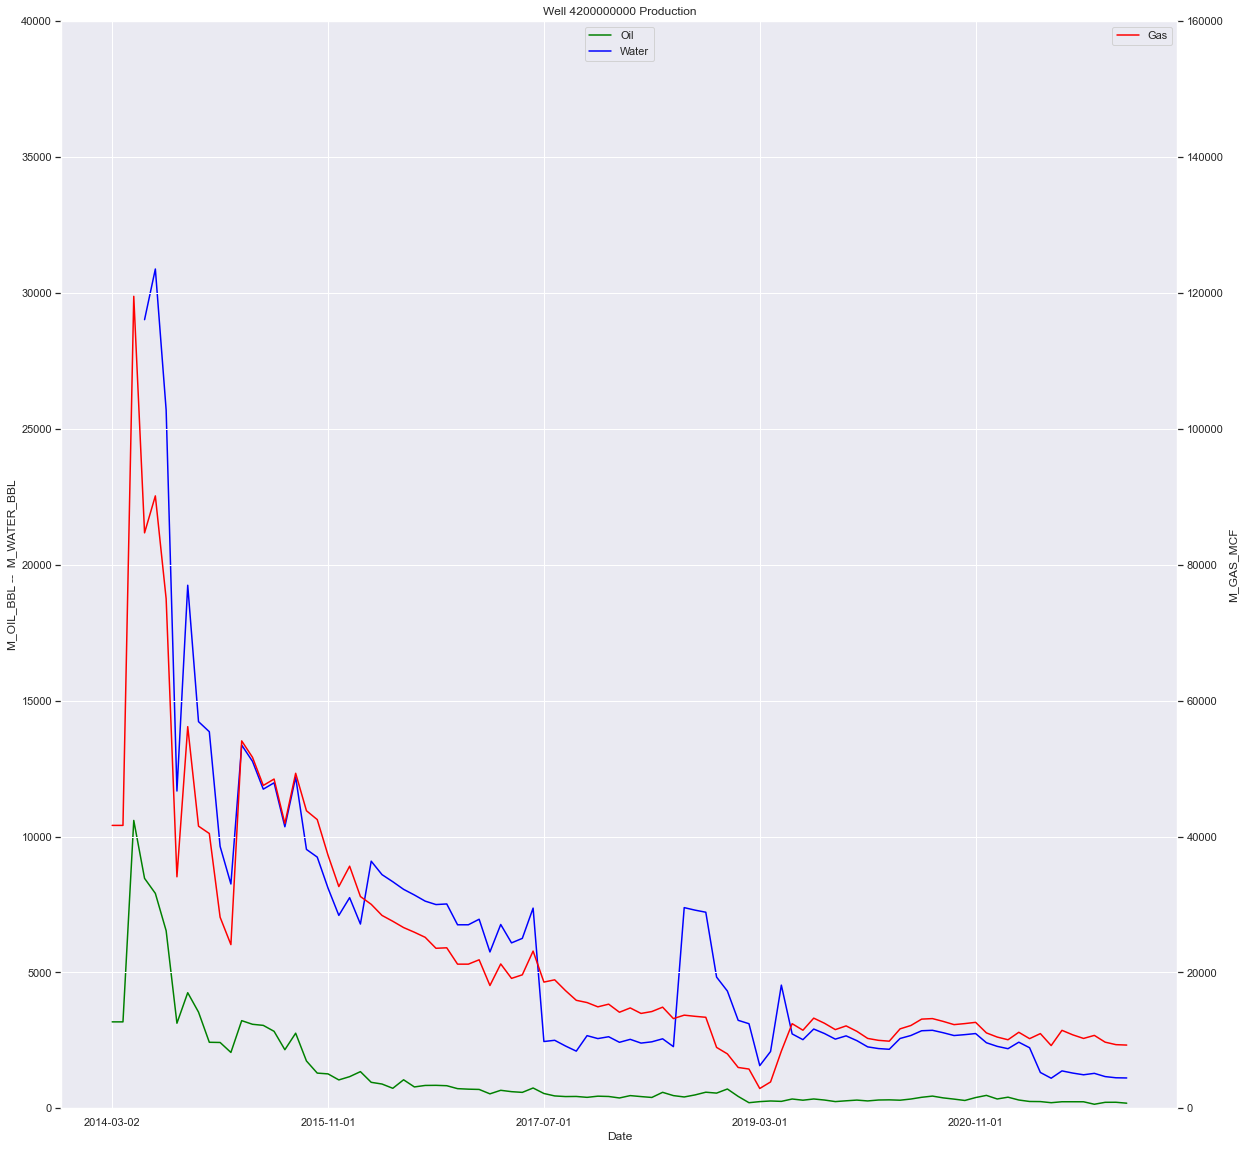

In [18]:
#Set API as Index
df_monthly.set_index('API', inplace=True)
#Get Well from las header
well=int(las.header['Well'][6].value)

#Plot Monthly Prod for Well A
df_singlewell = df_monthly.loc[well].set_index('proddate')
fig, ax = plt.subplots()
sns.set(rc={'figure.figsize':(20,20)})
sns.lineplot(data=df_singlewell, x='proddate', y='M_OIL_BBL', color='green')
sns.lineplot(data=df_singlewell, x='proddate', y='M_WATER_BBL', color='blue')
ax.set_ylim(0, 40000)
ax.set(xlabel='Date', ylabel='M_OIL_BBL --  M_WATER_BBL', title='Well '+str(well)+' Production')
ax.legend(labels=['Oil', 'Water'], loc='upper center')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax2=plt.twinx()
sns.lineplot(data=df_singlewell, x='proddate', y='M_GAS_MCF', color='red', ax=ax2)
ax2.set_ylim(0, 160000)
ax2.legend(labels=['Gas'])
plt.show()


In [12]:
#Calculate Cumulative Prod
well_list=[]
cum_prod = pd.DataFrame(columns=['Well','Total Oil Prod', 'Total Gas Prod', 'Total Water Prod'])

for well in wells:
   df_singlewell = df_monthly.loc[well].set_index('proddate')
   well_list.append(int(well))
   well_list.append(df_singlewell['M_OIL_BBL'].sum())
   well_list.append(df_singlewell['M_GAS_MCF'].sum())
   well_list.append(df_singlewell['M_WATER_BBL'].sum())
   cum_prod.loc[len(cum_prod)] = well_list
   # cum_prod = cum_prod.append(pd.Series(well_list, index=cum_prod.columns), ignore_index=True)
   well_list=[]

cum_prod['Well']=cum_prod['Well'].astype('int64')
cum_prod

,Well,Total Oil Prod,Total Gas Prod,Total Water Prod
0,4210932294,174.0,259757.0,132264.0
1,4210932339,52186.0,1095508.0,123486.0
2,4210932344,27734.0,1300762.0,177316.0
3,4210932345,28451.0,2034409.0,341595.0
4,4210932346,19038.0,1909938.0,174035.0
...,...,...,...,...
92,4210932590,318631.0,4031960.0,1538168.0
93,4210932592,214760.0,2576657.0,311994.0
94,4210932593,193437.0,1892454.0,307977.0
95,4210932604,84281.0,1447358.0,369343.0


In [13]:
# 6 MCF (6,000 cubic feet of natural gas) equals 1 BOE.
cum_prod['Total BOE'] = cum_prod['Total Oil Prod'] + cum_prod['Total Gas Prod']/6
cum_prod['Total BOE'] = cum_prod['Total BOE'].round(1)
cum_prod['Well']=cum_prod['Well'].astype('int64')
cum_prod

,Well,Total Oil Prod,Total Gas Prod,Total Water Prod,Total BOE
0,4210932294,174.0,259757.0,132264.0,43466.8
1,4210932339,52186.0,1095508.0,123486.0,234770.7
2,4210932344,27734.0,1300762.0,177316.0,244527.7
3,4210932345,28451.0,2034409.0,341595.0,367519.2
4,4210932346,19038.0,1909938.0,174035.0,337361.0
...,...,...,...,...,...
92,4210932590,318631.0,4031960.0,1538168.0,990624.3
93,4210932592,214760.0,2576657.0,311994.0,644202.8
94,4210932593,193437.0,1892454.0,307977.0,508846.0
95,4210932604,84281.0,1447358.0,369343.0,325507.3


In [14]:
# Filtering and moving data to csv
cum_prod_filter = cum_prod.where(cum_prod['Total BOE'] > 100000).dropna()
cum_prod_filter['Well']=cum_prod_filter['Well'].astype('int64')
print(cum_prod_filter)
cum_prod_filter.to_csv('TotalBOE_Filtered.csv')

          Well  Total Oil Prod  Total Gas Prod  Total Water Prod  Total BOE
1   4210932339         52186.0       1095508.0          123486.0   234770.7
2   4210932344         27734.0       1300762.0          177316.0   244527.7
3   4210932345         28451.0       2034409.0          341595.0   367519.2
4   4210932346         19038.0       1909938.0          174035.0   337361.0
5   4210932351         13135.0       1141220.0           85697.0   203338.3
..         ...             ...             ...               ...        ...
92  4210932590        318631.0       4031960.0         1538168.0   990624.3
93  4210932592        214760.0       2576657.0          311994.0   644202.8
94  4210932593        193437.0       1892454.0          307977.0   508846.0
95  4210932604         84281.0       1447358.0          369343.0   325507.3
96  4210932605        121717.0       2006665.0          337932.0   456161.2

[94 rows x 5 columns]


In [15]:
# calculate Max BOE Prod
cum_prod_max = cum_prod.where(cum_prod['Total BOE'] == cum_prod['Total BOE'].max()).dropna()
cum_prod_max['Well']=cum_prod_max['Well'].astype('int64')
cum_prod_max

,Well,Total Oil Prod,Total Gas Prod,Total Water Prod,Total BOE
86,4210932581,354300.0,6601084.0,1139335.0,1454480.7
